# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository:

Link to nbviewer render:

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [1]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

FASTA_PATH = "P62593.fasta" # Path to P62593.fasta
EMB_PATH = "P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-icbi0coq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-icbi0coq
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105419 sha256=1ce145f00550cecd9e387c1cf1f764f47a214704178fc95892e8b04d59549c24
  Stored in directory: /tmp/pip-ephem-wheel-cache-4667ck1h/wheels/73/b8/59/2a3415340d3dec5ae3d9ce69f8d7eb22674be68a4402b39f7a
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  30.8M      0 --:--:-- --:--:-- --:--:-- 30.9M
 

In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

<ipython-input-2-e907ffff8eb5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

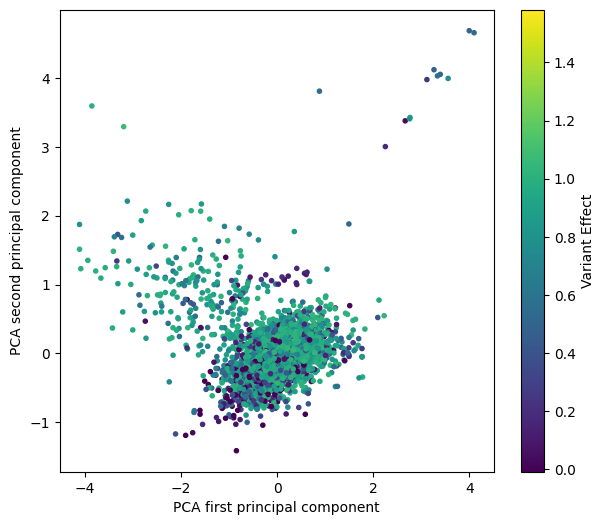

In [3]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$


#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?


#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

#### [5 Points] 1.4 Can bias and variance decrease at the same time?


## Answers below:

#### Answers 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$

Plugging in $y = f(x) + \epsilon$

$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \mathbb{E}_{D} \left[(  f(x) + \epsilon - \hat{f}(x) )^2\right] \\
= \mathbb{E}_{D} \left[ (f(x))^2 + \epsilon^2 + (\hat{f}(x))^2
+ \epsilon(f(x) - \hat{f}(x)) + f(x)(  \epsilon - \hat{f}(x) ) - \hat{f}(x)( f(x) + \epsilon)
\right]
$$

Moving things arounds (and aiming for the decomposition written above)
$$= \mathbb{E}_{D} \left[ (f(x))^2  + (\hat{f}(x))^2 - 2 f(x)\hat{f}(x) \right]
+ \mathbb{E}_{D}\left[
\epsilon(f(x) - \hat{f}(x)) + f(x) \epsilon - \hat{f}(x)\epsilon \right]
+ \mathbb{E}_{D} \left[ \epsilon^2
\right] \\
= \mathbb{E}_{D} \left[ ( \hat{f}(x) - f(x) )^2 \right] +
2 \mathbb{E}_{D}\left[ \epsilon ( \hat{f}(x) - f(x) ) \right] +
\mathbb{E}_{D} \left[ \epsilon^2 \right]
$$

Since $\epsilon \sim N(0, \sigma^2)$, $\mathbb{E}_{D}[\epsilon]=0$ and  $\mathbb{E}_{D}[\epsilon^2]=\sigma_2$.
Therefore, since by this construction for $\epsilon$, it is independent of $f(x)$ and $\hat{f}(x)$, we know that

$$ 2 \mathbb{E}_{D}\left[ \epsilon ( \hat{f}(x) - f(x) ) \right] =
2 \mathbb{E}_{D}\left[\epsilon \right] \mathbb{E}_{D}\left[ \hat{f}(x) - f(x) \right]
=0 $$.

So,
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] =  \mathbb{E}_{D} \left[ ( \hat{f}(x) - f(x) )^2 \right] + \mathbb{E}_{D} \left[ \epsilon^2 \right]  $$


Since $\epsilon = y - f(x)$,  $\epsilon^2 = ( y - f(x) )^2$, so  $\mathbb{E}_{D} \left[ \epsilon^2 \right] = \mathbb{E}_D\left[ (y - f(x))^2 \right]$, and based on how we're constructing our predictor, $ \mathbb{E}_D\left[ (y - f(x))^2 \right] = \mathbb{E}_D\left[ (\hat{f}(x) - \mathbb{E}[ \hat{f}(x)] )^2 \right] $

By plugging in this expression, we find the bias-variance tradeoff

$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$

#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

High bias indicates that the predictions are consistently deviating away from the true labels in the same direction. This is typically caused by either underfitting, or applying models that do not fit the data in question well, often times with incorrect descriptions of noise.

#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

A high-variance model will see large changes to predictions as a result of small changes in training inputs. This is typically obesrved during overfitting, often with highly parameterized models, which will have a tendency to model random noise as relevant signals.


#### [5 Points] 1.4 Can bias and variance decrease at the same time?
In some extreme cases, yes. Since is possible to have models of both infinitely high bias and variance simultaneously, in these cases changing to any reasonable model would decrease both. However, in practice, within the context of most reasonable methods (for example, within the context of adjusting just the regularization parameter in a linear model), it is not possible to decrease both, and so there is a tradeoff between the two.

# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?



## Answers below

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss

Adding the bias regularization term for $\beta$ is an assumption that for any $j$, $\beta_j \sim \mathcal{N}(0, \sigma_{\text{reg}}^2)$, for some variance $\sigma_{\text{reg}}^2$. It is also assumed that all $\beta$ are i.i.d, and so the covariance matrix of $\beta$ is a diagonal matrix, with all diagonal values of $\sigma_{\text{reg}}^2$. Therefore, the probability of any $\beta$ is given by the pdf of hte multivariate normal distribution
$$ f(\beta)={\frac {\exp \left(-{\frac {1}{2}}\left({\beta}\right)^{\mathrm {T} }{\boldsymbol {\Sigma_{\text{reg}} }}^{-1}\left({\beta}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma_{\text{reg}} }}|}}} $$

The log-likelihood of $\beta$ under this construction is
$$ \log f(\beta) = \text{Constant} + -\frac{1}{2\sigma_{\text{reg}}^2}\beta^T\beta
$$
For the regularization loss, we take the negaive log-likelihood, ignore the constant term, and we will absorb the $-\frac{1}{2\sigma_{\text{reg}}^2}$ into a $\lambda$ hyperparameter.


To derive the prediction loss, we apply the similar assumptions of multivariate normal distrubtions on i.i.d variables, such that $y \sim \mathcal{N}(X\beta, \Sigma)$. We again derive the pdf of the multivariate normal distribution, noting that $\Sigma$ is a diagonal matrix, and take the log-likelihood:

$$ f_1(y, X)={\frac {\exp \left(-{\frac {1}{2}}\left({X\beta-y}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({X\beta - y}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}} $$

The log-likelihood of $\beta$ under this construction is
$$ \log f_1(y, X) = \text{Constant} + -\frac{1}{2\sigma^2}(X\beta-y)^T(X\beta-y)
$$

Putting it all together, the loss corresponds to the sum of the negative log-likelihoods of the regularization and prediction losses, with the optimization problem being the find $\text{argmax}_{\beta}(\mathcal{L}):

$$\mathcal{L}' =  \log f_1(y, X) +  \log f(\beta)\\
= \text{Constant} + \frac{1}{2\sigma^2}(X\beta-y)^T(X\beta-y) + \frac{1}{2\sigma_{\text{reg}}^2}\beta^T\beta$$.

Since the argmax with respect to $\beta$ is invariant tp scaling by constants, we divide through by $\frac{1}{2\sigma^2}$ and absorb all constants into a $\lambda$ hyperparameter:

$$\mathcal{L} = (\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta \\
\hat{\beta} = \text{argmax}_{\beta}\left[ (\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta \right] $$

To optimize, we take the derivative with respect to $\beta$ and set it to 0, with I as the identity matrix:
$$\frac{d}{d\beta} \mathcal{L} =  2 \textbf{X}^T \textbf{X} \beta - 2\textbf{X}^T y + 2\lambda I \beta = 0
$$
Solving for $\beta$, and diving through by the constant 2:
$$ \left( \textbf{X}^T \textbf{X} + \lambda I \right)\beta  = \textbf{X}^T y
$$
Therefore, the optimal solution to ridge regression is given by:
$$\hat{\beta} = \left( \textbf{X}^T \textbf{X} + \lambda I \right)^{-1} \textbf{X}^T y $$

Also, we note that the second derivative is greater than zero, so this optimal $\hat{\beta}$ solution does minimize the given loss.


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

Success!

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?
The training MSE will always increase as we increase the lambda parameter, as it forces us to deviate from the optimal analytical solution within the training set. The MSE on a test set will initially decrease, but then increase as the regularization gets too strong. The variance consistently decreases as the labmda parameter increases. Thus, we see the bias-variance tradeoff occur within the range of regularization hyperparameters.

In [4]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.inv(XTX + self.lambda_reg * I ) @ XTy  # TODO: Fill in

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean(np.power(y_true-y_pred, 2))

In [5]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

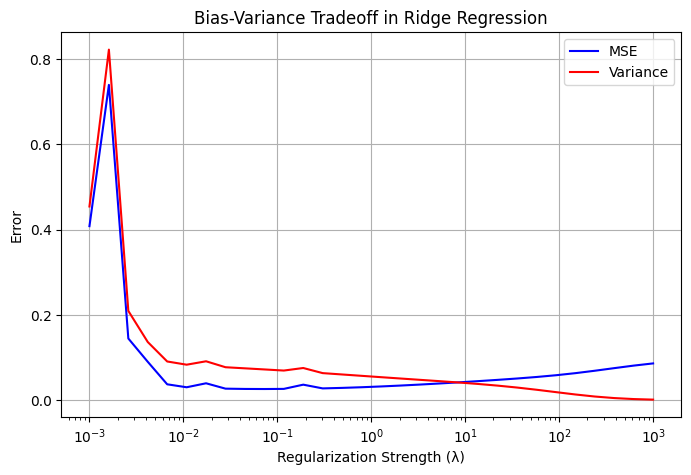

In [6]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

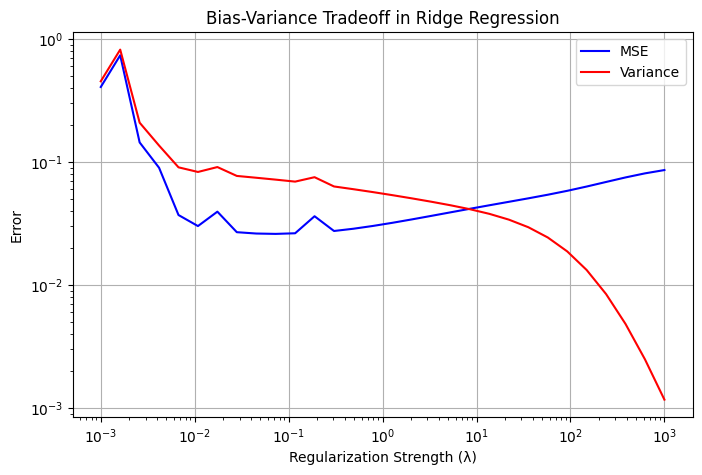

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.yscale('log')
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?


## Answers below

#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?
The role of the $\gamma$ parameter is used to determine which components of $\beta$ are used in the model. When $\gamma_j$=1, the corresponding $beta_j$ is simply 0. When $\gamma_j=0$, then the $\beta_j$ follows the ridge regression regularization, which allows it to take nonzero values.



#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

We want to maximize $p(\gamma, \beta | \textbf{X}, \textbf{y},  \sigma^2, p)$, which corresponds to, by the definition of conditional probability
$$
p(\gamma, \beta | \textbf{X}, \textbf{y}, \sigma^2, p) = \text{Constant} \cdot \
    p(\beta | \textbf{X}, \textbf{y}, \sigma^2, \gamma) \cdot  
     p(\gamma| \textbf{X}, \textbf{y}, \sigma^2, p )
$$

Applying Bayes' theroem (and dropping conditionally independent conditionals, where applicable):
$$ p(\beta | \textbf{X}, \textbf{y}, \sigma^2, \gamma)
    = \frac{ P(\textbf{y} | \textbf{X}, \beta, \gamma) \cdot P( \beta | \gamma_j) }{ P(X, Y|\sigma^2, \gamma)}
$$
We assume that this denominator is constant, so we drop it in subsequent derivations.

Now, the relevant distrubtions are:
$$
y \sim \mathcal{N}(\mathbf{X}( \gamma \circ \beta ), \sigma_2 ) \\
\beta_j \sim \mathcal{N}(0, \sigma_{\beta}^2) \\
\gamma_j \sim \text{Bernoulli}(p)
$$

We then apply these elements to the posterior objective
$$
p(\gamma, \beta | \textbf{X}, \textbf{y}, \sigma^2, p) = P(\textbf{y} | \textbf{X}, \beta, \gamma) \cdot P( \beta | \gamma_j ) \cdot P(\gamma | p )
$$

As demonstrated in the earlier question, we have

$$ P(y |  \textbf{X}, \beta, \gamma )={\frac {\exp \left(-{\frac {1}{2}}\left({X(\gamma \circ \beta)-y}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({X(\gamma \circ \beta ) - y}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}} $$

$$ P(\beta)={\frac {\exp \left(-{\frac {1}{2}}\left({\beta}\right)^{\mathrm {T} }{\boldsymbol {\Sigma_{\beta} }}^{-1}\left({\beta}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma_{\beta} }}|}}} $$

$$  P(\gamma_j | p ) = (\gamma_j)p + (1-\gamma_j)(1-p)
$$

Therefore, the posterior objective is
$$ p(\gamma, \beta | \textbf{X}, \textbf{y}, \sigma^2, p) =
{\frac {\exp \left(-{\frac {1}{2}}\left({X(\gamma \circ \beta)-y}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({X(\gamma \circ \beta ) - y}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}} \cdot
{\frac {\exp \left(-{\frac {1}{2}}\left({\beta}\right)^{\mathrm {T} }{\boldsymbol {\Sigma_{\beta} }}^{-1}\left({\beta}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma_{\beta} }}|}}}  \\ \cdot
\prod_{j=1}^d \left[ (\gamma_j)p + (1-\gamma_j)(1-p) \right]
$$

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

The posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high indicates that the corresponding feature $j$ is not used in the model. The plot is mostly values centered at 0.5, which indicates that the $\beta$s were divided by two across most cases. There were more exceptions on the lower end, which indicates that some features were used fully in the model. The fact that none were at, or close to, 1 indicates that no features were completely removed.

In [8]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()


Output()

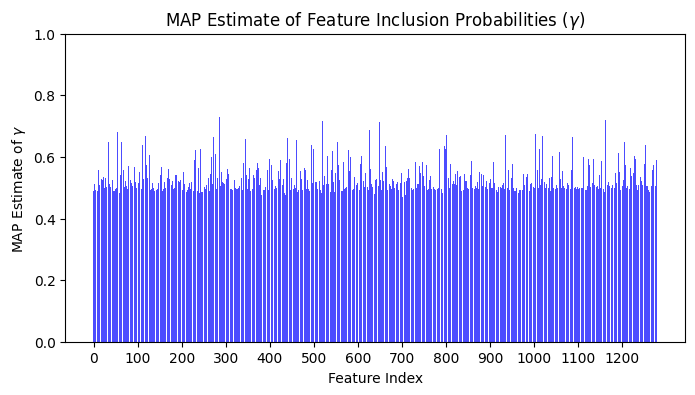

In [9]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

# [10 Points] Question 3: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.logspace(-5, 5, 11) } #TODO: Fill in

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(ridge_model,
                           param_grid,
                           cv=3 ## as specified in the commented directions
                           ) #TODO: Fill in
grid_search.fit(Xs_train, ys_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])})

In [12]:
print('Best parameter: {}'.format(grid_search.best_params_))

Best parameter: {'alpha': 0.1}


In [13]:
print('Train MSE: {:.3e}'.format(
                    np.mean(
                            np.power(ys_train - grid_search.predict(Xs_train),
                                     2)
                                    ) )

     )
print('Test MSE: {:.3e}'.format(
                    np.mean(
                            np.power(ys_test - grid_search.predict(Xs_test),
                                     2)
                                    ) )

     )

Train MSE: 1.793e-02
Test MSE: 2.579e-02


In [14]:
print('Success!')

Success!
